# CSV File importation

This python notebook example shows two *different ways* to import a CSV file of a standardised drive cycle (Artemis Urban):

* with CSV module and the reader function,
* with pandas module and the read_csv function.

For each way, data are loaded and displayed in a graph.

In [5]:
from aesim.simba import ProjectRepository
import matplotlib.pyplot as plt
import os 
import numpy as np

#script_folder = os.path.realpath(os.path.dirname(__file__))
notebook_folder = os.path.join(os.getcwd())
csv_filename = notebook_folder + '/ArtUrban.csv'
csv_file = open(csv_filename)

### First way: use of reader function of csv module

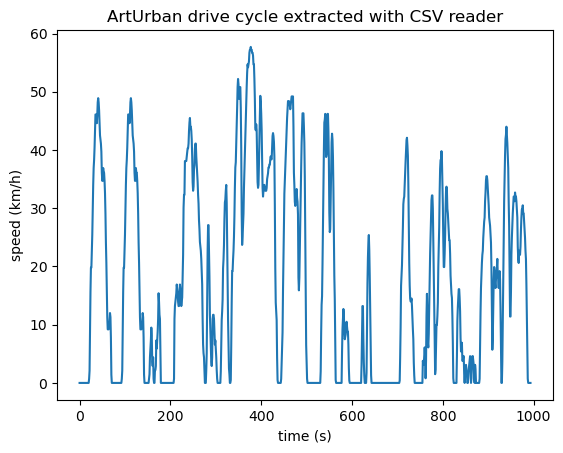

In [6]:
import csv
time = []
speed = []
for kLine, line in enumerate(csv.reader(csv_file)):
    if kLine == 0:
        xlabel = line[0]
        ylabel = line[1]
    if kLine > 0:
        time.append(float(line[0]))
        speed.append(float(line[1]))

fig = plt.figure()
plt.plot(time, speed)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('ArtUrban drive cycle extracted with CSV reader')
plt.show()

### Second way: use of read_csv function of pandas module

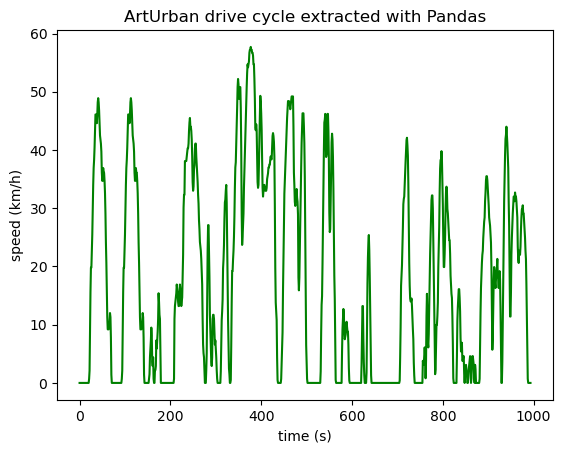

In [7]:
import pandas as pd
df = pd.read_csv(csv_filename)
time = df['time (s)'].to_numpy()
speed = df['speed (km/h)'].to_numpy()

fig = plt.figure()
plt.plot(time, speed, 'g')
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title('ArtUrban drive cycle extracted with Pandas')
plt.show()

### Use example:
This notebook shows then an example to compute the required DC power with the following steps:

* Compute of the *tractive force* and the *power-to-wheel* of an electric vehicule
* Load this power-to-wheel data into a *piece-wise-linear* control source element in a Simba circuit
* Consider typical efficiencies of a motor and an inverter
* Simulate and plot DC bus power and power to wheel

![Simba circuit](fig/power2wheel_circuit.png)

========== 0 Error(s), 0 Warning(s) ==========
Job duration: 0,0044889 seconds.


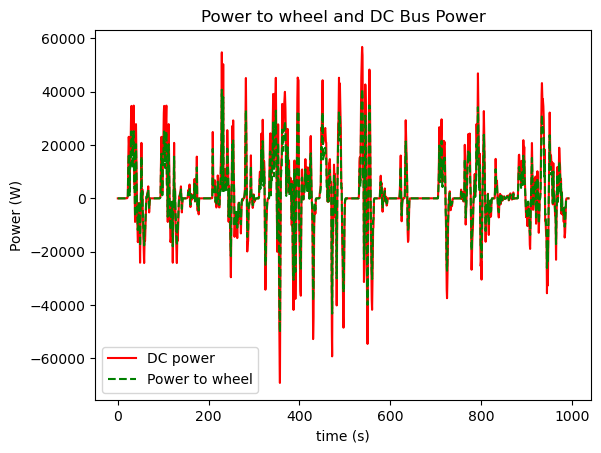

In [8]:
# Computation of Power to wheel
speed_ms = speed * 1e3 / 3600
acceleration = np.diff(speed_ms) / np.diff(time)
acceleration = np.insert(acceleration, 0, 0)

mass = 2057    # mass (kg)
a = 178.7      # rolling resistance on flat land (N)
b = 3.3084     # component of the rolling resistance (N / (m / s))
c = 0.5231952  # aerodynamic drag (N / (m / s²))

tractive_force = acceleration * mass + a + b * speed_ms + c * speed_ms**2
power_to_wheel = tractive_force * speed_ms

# Define method to transform time and power arrays into a string for the PWL control source
def arrays_to_str(time, values):
    # concatenate time and val arrays into a single array
    matrix = np.column_stack((time, values))
    # Convert matrix to strings
    rows_as_str = [' '.join(map(str, row)) for row in matrix]
    # Join rows with '; '
    return '[' + '; '.join(rows_as_str) + ']'

# Load design
simba_file_path = os.path.join(notebook_folder, "csv_file_import.jsimba")
project = ProjectRepository(simba_file_path)
design = project.GetDesignByName('Design')
# Get PWL control source
dc_power_block = design.Circuit.GetDeviceByName('DC-power')
dc_power_block.TimeValueMatrix.UserValue = arrays_to_str(time, power_to_wheel)
# Set DC bus voltages and efficiencies
design.Circuit.SetVariableValue("Udc", str(650))
design.Circuit.SetVariableValue("eff_motor", str(0.8))
design.Circuit.SetVariableValue("eff_inv", str(0.9))
# Simulation
design.TransientAnalysis.EndTime = time[-1]
design.TransientAnalysis.TimeStep = 0.1
job = design.TransientAnalysis.NewJob()
status = job.Run()
if status != "OK":
    print (job.Summary()[:-1])
# Get results
simutime = np.array(job.TimePoints)
dcBus_voltage = np.array(job.GetSignalByName('dcBus - Voltage').DataPoints)
dcBus_current = np.array(job.GetSignalByName('dcBus - Current').DataPoints)
dcBus_Power = dcBus_voltage * dcBus_current
# Plot
fig = plt.figure()
plt.plot(simutime, dcBus_Power, 'r', label="DC power")
plt.plot(time, power_to_wheel, 'g--', label="Power to wheel")
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('Power (W)')
plt.title('Power to wheel and DC Bus Power')
plt.show()